In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, f1_score, precision_recall_curve, accuracy_score
from sklearn.base import clone

# Phase 0 - Constants, Configs, and Functions

## Constants and Configs

In [2]:
mae = mean_absolute_error
RNG = 123456
ROUGHER_W, FINAL_W = 0.25, 0.75

# Enforce Category Order (for dtype+sorting)
ORDERED_CATEGORIES = {
    'stage':('rougher', 'primary_cleaner', 'secondary_cleaner', 'final'),
    'stream': ('feed', 'concentrate', 'tail'),
    'metal':('au', 'ag', 'pb')
}

# Enforce Column Order (for presentation)
ORDERED_COLUMNS = ('date', 'stage', 'stream', 'metal', 'conc')

# Stage and Streams template for EDA
stage_streams = [
    'rougher.input.feed_{}', 'rougher.output.concentrate_{}',
    'primary_cleaner.output.concentrate_{}', 'final.output.concentrate_{}'
]

## Functions

In [3]:
# Function that converts the 'date' column to the `datetime`, set new 'date' column as the index, and sort DataFrame by new 'date' column
def convert_datetime(df: pd.DataFrame, col: str = "date", drop_nat: bool = True):
    """
    Convert a datatime column to pandas datetime, set as index, and sort.
    - col: name of timestamp column
    - drop_nat: drop rows where datatime conversion failed (NaT)
    """
    if col not in df.columns:
        raise KeyError(f"Expected a '{col}' column, but columns were: {list(df.columns)[:10]}...")
    
    date_convert = df.copy()
    date_convert[col] = pd.to_datetime(date_convert[col], errors="coerce")

    if drop_nat:
        date_convert = date_convert[date_convert[col].notna()]
    
    return date_convert

In [4]:
# Function to Apply Consistent Order to Columns
def apply_ordering(
    df: pd.DataFrame,
    *,
    ordered_categories: dict = ORDERED_CATEGORIES,
    ordered_columns: tuple = ORDERED_COLUMNS,
    time_col: str | None = None,
    sort_time: bool = True,
    keep_time_as: str | None = None
):
    """
    Apply consistent ordering for EDA outputs:
        1) set ordered categoricals for stage/stream/metal (if those col exist),
        2) reorder columns (without breaking if some are missing),
        3) sort by time.
    """
    order2chaos = df.copy()

    # --- 1) Enforce ordered categoricals (only for columns that exist) ---
    for col, cats in ordered_categories.items():
        if col in order2chaos.columns:
            # Keep values not in cats as unordered tail so you do not lose them.
            existing = pd.Index(order2chaos[col].dropna().astype(str).unique())
            cats_set = set(map(str, cats))
            extras = [x for x in existing if x not in cats_set]
            full_cats = list(map(str, cats)) + sorted(extras)

            order2chaos[col] = pd.Categorical(order2chaos[col].astype(str),
                                               categories=full_cats, ordered=True)

    # --- 2) Reorder columns safely ---
    present_first = [c for c in ordered_columns if c in order2chaos.columns]
    remaining = [c for c in order2chaos.columns if c not in present_first]

    # Optional: bring a time column to the very front (if it's a column)
    if time_col and time_col in order2chaos.columns and time_col not in present_first:
        cols = [time_col] + present_first + [c for c in remaining if c != time_col]
    else:
        cols= present_first + remaining

    order2chaos = order2chaos.loc[:, cols]
    
    # --- 3) Sort by index (timestamp) ---
    if sort_time:
        # If index is datetime like, sort by index
        if isinstance(order2chaos.index, pd.DatetimeIndex):
            order2chaos = order2chaos.sort_index()
        # Else if time_col exists, try sorting by it (even if it's currently object)
        elif time_col and time_col in order2chaos.columns:
            # Convert to datetime if possible, without throwing a fit
            tc = pd.to_datetime(order2chaos[time_col], errors='coerce')
            # Sort using converted values when available
            order2chaos = (
                order2chaos.assign(_time_sort_key=tc)
                    .sort_values("_time_sort_key")
                    .drop(columns="-time_sort_key")
            )
        
    # Optional: rename time label for display
    if keep_time_as:
        if time_col and time_col in order2chaos.columns:
            order2chaos = order2chaos.rename(columns={time_col: keep_time_as})
        else:
            order2chaos = order2chaos.rename_axis(keep_time_as)

    return order2chaos

In [5]:
# Function to Verify 'Recovery' is calculated correctly
def recovery_calculation (C, F, T):
    numerator = C * (F - T)
    denomenator = F * (C - T)
    recovery_check = numerator/denomenator * 100
    return recovery_check

In [6]:
# Function to fill in missing values based on the chronological previous reading using the pandas.DataFrame.ffill() method
def impute_missing_values(df):
    df_filled = df.copy()
    df_filled = df_filled.ffill(axis=0)
    return df_filled

In [7]:
# Function to break down the long column names into an easier to look at table format
def long_table_format(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert wide Zyfra-style metal concentration columns into tidy long format.
    
    Returns columns: [index_name, stage, stream, metal, conc]
    """
    pattern = re.compile(
        r'^(rougher|primary_cleaner|secondary_cleaner|final)\.'
        r'(input\.feed|output\.concentrate|output\.tail)_'
        r'(au|ag|pb)$'
    )

    cols = [c for c in df.columns if pattern.match(c)]
    if not cols:
        raise ValueError("No metal concentration columns matched expected pattern.")
    
    # Handle index properly
    if df.index.name == 'date':
        df_work = df.reset_index()
        id_col = 'date'
    else:
        raise ValueError("Expected index to be named 'date'.")

    long = (
        df_work[cols + [id_col]]
        .melt(id_vars='date', var_name='tag', value_name='conc')
    )

    long[['stage', 'stream', 'metal']] = long['tag'].str.extract(pattern)

    long['stream'] = (
        long['stream']
        .str.replace('input.feed', 'feed', regex=False)
        .str.replace('output.concentrate', 'concentrate', regex=False)
        .str.replace('output.tail', 'tail', regex=False)
    )

    return long.drop(columns='tag')

In [8]:
# Function to compute basic summary stats
def basic_summary_stats(
        long_df: pd.DataFrame,
        *,
        value_col: str = 'conc') -> pd.DataFrame:
    """
    Compute robust summary statistics for metal concentrations.
    
    Returns:
    - n         : number of observations
    - missing   : fraction of missing values
    - median    : median concetration
    - q25/q75   : interquartile range
    """
    summary = (
        long_df
        .groupby(['stage', 'stream', 'metal'])
        .agg(
            n_total=(value_col, 'size'),
            n_non_missing=(value_col, 'count'),
            missing=(value_col, lambda s:s.isna().mean()),
            median=(value_col, 'median'),
            q25=(value_col, lambda s:s.quantile(0.25)),
            q75=(value_col, lambda s: s.quantile(0.75)),
            )
            .reset_index()
        )

    summary['missing_n'] = summary['n_total'] - summary['n_non_missing']
    
    for col, categories in ORDERED_CATEGORIES.items():
        if col in summary.columns:
            summary[col] = pd.Categorical(
                summary[col],
                categories=categories,
                ordered=True
            )
    
    return summary

In [9]:
# Function for Metal Concentrate Analysis Histogram 
def metal_conc_hist(metal):
    streams = [s.format(metal) for s in stage_streams]
    for stream in streams:
        full_data[stream].hist(alpha=0.5, bins=20)
        plt.legend(streams)

In [10]:
# Function for TimeSeriesSplit evaluator
def evaluate_models_tss_rmse_smape(
        X,
        y,
        models: dict,
        smape_fn,
        n_splits=5,
        test_size=None,
        gap=0,
        max_train_size=None,
        verbose=True
):
    """
    Evaluate multiple models with TimeSeriesSplit using RMSE.
    
    Returns:
        results: dict keyed by model name with:
            - 'fold_rmse': list of RMSE per fold
            - 'mean_rmse': float
    """
    # Safety: ensure time order & alignment
    X = X.sort_index()
    y = y.loc[X.index]

    tscv = TimeSeriesSplit(
        n_splits=n_splits,
        test_size=test_size,
        gap=gap,
        max_train_size=max_train_size
    )

    results = {}

    for model_name, model in models.items():
        fold_rmses = []
        fold_smapes = []

        for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            m = clone(model)    # fresh model each fold (important!)
            m.fit(X_train, y_train)
            
            preds = m.predict(X_test)
            rmse = root_mean_squared_error(y_test, preds)
            smape_val = smape_fn(y_test, preds)

            fold_rmses.append(rmse)
            fold_smapes.append(smape_val)

            if verbose:
                print(
                   f"{model_name} | Fold {fold} "
                   f"RMSE: {rmse:.4f} | sMAPE: {smape_val:.2f}%"  
                )

        results[model_name] = {
            "fold_rmse": fold_rmses,
            "mean_rmse": float(np.mean(fold_rmses)),
            "fold_smape": fold_smapes,
            "mean_smape": float(np.mean(fold_smapes))
        }

        if verbose:
            print(
                f"{model_name} | Mean RMSE: {results[model_name]['mean_rmse']:.4f} "
                f"| Mean sMAPE: {results[model_name]['mean_smape']:.2f}%\n"
            )

    return results

In [11]:
# Function for a Quick "who won?" Summary
def summarize(results_dict, label):
    print(f"\n=== {label} Summary ===")
    for name, res in results_dict.items():
        print(
            f"{name:20s} "
            f"RMSE={res['mean_rmse']:.4f} "
            f"sMAPE={res['mean_smape']:.2f}% "
        )

In [12]:
# Function to calculate sMAPE value
def calculate_smape(actuals, predicted) -> float:
    """
    Symmetric Mean Absolute Percentage Error (sMAPE), in percent.

    Parameters
    ----------
    actuals: array-like
    predicted: array-like
    eps: float
        Small value to avoid division by zero.
    
    Returns
    -------
    float
        sMAPE value (percentage).
    """

    actuals = np.asarray(actuals, dtype=float).ravel()
    predicted = np.asarray(predicted, dtype=float).ravel()

    if actuals.shape != predicted.shape:
            raise ValueError(f"Shape Mismatch: {actuals.shape} vs {predicted.shape}")
        
    denom = (np.abs(actuals) + np.abs(predicted)) / 2.0
    diff = np.abs(actuals - predicted)

    terms = np.where(denom == 0, 0.0, diff / denom)
    return float(np.mean(terms) * 100.0)

In [13]:
# Function for Model Selection with Stage sMAPE
def final_smape_from_stage_scores(r_smape: float, f_smape: float) -> float:
    return ROUGHER_W * r_smape + FINAL_W * f_smape

In [14]:
# Function to calculate the final sMAPE value
def final_smape(r_actuals, r_preds, f_actuals, f_preds) -> float:
    r = calculate_smape(r_actuals, r_preds)
    f = calculate_smape(f_actuals, f_preds)
    return final_smape_from_stage_scores(r,f)

# Phase 1 - Prepare the Date

## Step 1.1 - Read Dataset into DFs and Analysis the Data

In [15]:
train_data = pd.read_csv('datasets/gold_recovery_train.csv')
test_data = pd.read_csv('datasets/gold_recovery_test.csv')
full_data = pd.read_csv('datasets/gold_recovery_full.csv')

#train_data.info()
#print(train_data.head(5))
#test_data.info()
#print(test_data.head(5))
#full_data.info()
#print(full_data.head(5))

In [16]:
# Convert 'date' column to the datetime dtype, set it as the index, and sort by it for all three datasets
train_df_date_convert = convert_datetime(train_data, col='date', drop_nat=True) \
    .sort_values('date').set_index('date')
test_df_date_convert = convert_datetime(test_data, col='date', drop_nat=True) \
    .sort_values('date').set_index('date')
full_df_date_convert = convert_datetime(full_data, col='date', drop_nat=True) \
    .sort_values('date').set_index('date')

# Apply Consistent Order to Columns of training and test datasets
train_data_ordered = apply_ordering(
    train_df_date_convert,
    ordered_categories=ORDERED_CATEGORIES,
    ordered_columns=ORDERED_COLUMNS,
    time_col=None,
    sort_time=True,
    keep_time_as=None
)

test_data_ordered = apply_ordering(
    test_df_date_convert,
    ordered_categories=ORDERED_CATEGORIES,
    ordered_columns=ORDERED_COLUMNS,
    time_col=None,
    sort_time=True,
    keep_time_as=None
)

## Step 1.2 - Check that ***RECOVERY*** is calculated correctly

- Calculate ***RECOVERY*** for the `rougher.output.recovery` feature
- Find MAE between my calculations and the values in the feature within `gold_recovery_train`

In [17]:
# Variables for 'recovery_calculation'
r_feed = train_data['rougher.input.feed_au']
r_concentrate = train_data['rougher.output.concentrate_au']
r_tails = train_data['rougher.output.tail_au']

# Calculation to verify the 'rougher.output.recovery' feature within the Training Set
rougher_recovery_check = recovery_calculation(r_concentrate, r_feed, r_tails)
train_data['rougher.output.recovery_check'] = rougher_recovery_check

# Calculate the 'Mean Absolute Error' between 'rough_recovery_check' and 'rougher.output.recovery' in training set, while ignoring any rows with NaN
mask = train_data['rougher.output.recovery'].notna() & \
       train_data['rougher.output.recovery_check'].notna()

rougher_recovery_mae = mae(train_data.loc[mask, 'rougher.output.recovery'],
                           train_data.loc[mask, 'rougher.output.recovery_check'])
# train_data['rougher.output.recovery.mae'] = rougher_recovery_mae

print(rougher_recovery_mae)


9.210911277458828e-15


### Findings of ***RECOVERY*** verification

- When the `recovery` calculation was performed it created 14,577 non-null values; however, the training dataset's original `recovery` feature had 14,287 non-null values.
- Since there is a 290 non-null values difference, to calculate the `mean_absolute-error` I needed to filter the dataset to only calculate the `mean_absolute-error` if there are no NaN values in either column used for this calculation for each row.
- The `mae` for the `rougher.output.recovery` calculation is 9.210911277458828e-15. This is essentially zero 

## Step 1.3 - Analyze Features in the Test Set
- What are these parameters?
- What is their type?

In [18]:
test_data.info()

# Extract column headings
train_columns = train_data.columns.tolist()
test_columns = test_data.columns.tolist()

# Determine the maxmium length for consistent column creation
max_len = max(len(train_columns), len(test_columns))

# Pad the shorter list with None
train_columns_padded = train_columns + [None] * (max_len - len(train_columns))
test_columns_padded = test_columns + [None] * (max_len - len(test_columns))

# Create new DataFrame
feature_compare = pd.DataFrame({
    'Train_Column_Headings': train_columns_padded,
    'Test_Column_Headings': test_columns_padded
})

# Filter for Missing Features in 'test_data'
missing_features = feature_compare[feature_compare['Test_Column_Headings'].isna()]

missing_features.info()

# Get data types for missing columns in 'test_data'
missing_dtypes = train_data[missing_features['Train_Column_Headings']].dtypes

# Merge back into 'feature_compare'
feature_compare['train_dtypes'] = feature_compare['Train_Column_Headings'].map(train_data.dtypes)

feature_compare.loc[feature_compare['Test_Column_Headings'].isna(),
                    ['Train_Column_Headings', 'train_dtypes']]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

,Train_Column_Headings,train_dtypes
53,rougher.state.floatbank10_a_air,float64
54,rougher.state.floatbank10_a_level,float64
55,rougher.state.floatbank10_b_air,float64
56,rougher.state.floatbank10_b_level,float64
57,rougher.state.floatbank10_c_air,float64
58,rougher.state.floatbank10_c_level,float64
59,rougher.state.floatbank10_d_air,float64
60,rougher.state.floatbank10_d_level,float64
61,rougher.state.floatbank10_e_air,float64
62,rougher.state.floatbank10_e_level,float64


### Results of Analysis of Features in the Test Set

- Missing the air and fluid level paramters for flotation unit #10 in the "Flotation" stage.
- Missing the Output Recovery Check performed in step 1.2 above for the "Flotation" stage 
- Missing the paramters for the product residue for silver, lead, colloidal suspension, and gold for the "2nd Stage Purification" process.
- Missing the air and fluid level paramters for the 6 flotation units in the "2nd Stage Purification" process.
- All these parameters are "float" data types.

## Step 1.4 - Data Preprocessing

- Handle Missing Values (Critical)
- Remove Data Leakage (Absolutely Essential)
- Align Training and Test Feature Sets
- Fix Data Types (Important)
- Outlier Treatment (Be Surgical)
- Feature Scaling (Model-Dependent)
- Target Preparation
- Perform Sanity Check Before Modeling

In [19]:
# Analyzing Missing Values
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


### Analysis of Train Data Set

- Target (Need to Drop):
    - Column 5 `final.output.recovery`
    - Column 48 `rougher.output.recovery`
- Leakage Columns (Need to Drop):  
        Any column starting with the following:  
    - `final.output` -- 1-4, 6-9
    - `primary_cleaner.output` -- 14-21
    - `rougher.output` -- 44-47, 49-52
    - `secondary_cleaner.ouput` -- 65-68
- Irrelevant Data (Need to Drop):
    - Column 0 `date`
    - Column 30 `rougher.calculation.sulfate_to_au_concentrate`
    - Column 31 `rougher.calculation.floatbank10_sulfate_to_au_feed`
    - Column 32 `rougher.calculation.floatbank11_sulfate_to_au_feed`
    - Column 33 `rougher.calculation.au_pb_ratio`
- Features:
    Any column starting with the following:
    - `primary_cleaner.input` -- 10-13
    - `primary_cleaner.state` -- 22-29
    - `rougher.input` -- 34-43
    - `rougher.state` -- 53-64
    - `secondary_cleaner.state` -- 69-86

## Step 1.4 - Data Preprocessing

In [20]:
# Creating variables for Target Data, Leakage Data, and Irrelevant Data columns
target_cols = [
    'rougher.output.recovery',
    'final.output.recovery'
]

leakage_cols = [
    col for col in train_data_ordered.columns
    if ('output' in col or 'calculation' in col)
    and col not in target_cols
]

irrelevant_cols = [
    col for col in train_data_ordered.columns
    if col.endswith('_id')
]

drop_cols = target_cols + leakage_cols + irrelevant_cols

#print(drop_cols)

In [21]:
# Creating Clean Feature (x) and Target (y) DF - Minus "target_cols", "leakage_cols", and "irrelevant_cols"
clean_train_x = train_data_ordered.drop(columns=drop_cols)
clean_train_y = train_data_ordered[target_cols]

In [22]:
# Analyze clean_train dataframes to look at the missing values issue
#clean_train_x.info()

# Ensure chronological order
clean_train_x = clean_train_x.sort_index()
# Filling in missing values using impute_missing_values() Function
filled_clean_train_x = impute_missing_values(clean_train_x)

filled_clean_train_x.info()
clean_train_y.info()
clean_train_y['final.output.recovery'].isna().any()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               16860 non-null  float64
 1   primary_cleaner.input.depressant            16860 non-null  float64
 2   primary_cleaner.input.feed_size             16860 non-null  float64
 3   primary_cleaner.input.xanthate              16860 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      16860 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    16860 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      16860 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    16860 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      16860 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    1686

True

In [23]:
# Handling Missing Values in the Targets - drop the rows with missing target values
# For final.output.recovery
mask_r = clean_train_y['rougher.output.recovery'].notna()
rougher_X_train = filled_clean_train_x.loc[mask_r]
rougher_y_train = clean_train_y.loc[mask_r, 'rougher.output.recovery']

# For final.output.recovery
mask_f = clean_train_y['final.output.recovery'].notna()
final_X_train = filled_clean_train_x.loc[mask_f]
final_y_train = clean_train_y.loc[mask_f, 'final.output.recovery']

#clean_train_y.info()
rougher_X_train.info()
final_X_train.info()
rougher_y_train.info()
final_y_train.info()

# Sanity check to verify the filtered versions are the same between the features and targets
assert rougher_y_train.notna().all()
assert rougher_X_train.shape[0] == rougher_y_train.shape[0]
assert final_y_train.notna().all()
assert final_X_train.shape[0] == final_y_train.shape[0]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14287 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               14287 non-null  float64
 1   primary_cleaner.input.depressant            14287 non-null  float64
 2   primary_cleaner.input.feed_size             14287 non-null  float64
 3   primary_cleaner.input.xanthate              14287 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      14287 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    14287 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      14287 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    14287 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      14287 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    1428

# Phase 2 - EDA
- Take note of how the concentration of metals (Au, Ag, Pb) change depending on the purification stage.
- Compare the feed particle size distributions in the training set and the test set. If the distributions vary significantly, the model evaluation will be incorrect.
- Consider the total concentrations of all substances at different stages:raw feed, rougher concentrate, adn final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.

 ## Step 2.1 - How does the concetration of metals (Au, Ag, Pb) change based on stage?

Text(0.5, 1.0, 'Gold Concentrate Change')

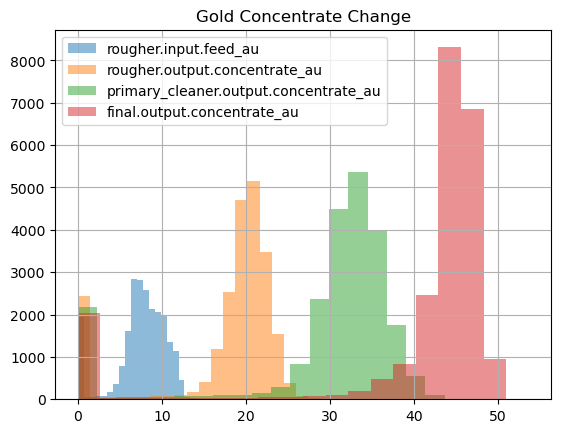

In [24]:
# Histogram plot for Change in Gold Concentrate
metal_conc_hist('au')
plt.title('Gold Concentrate Change')

- Gold concentration starts out fairly low with a high degree of variability as shown by the `rougher.input.feed` measurement. However, it is clear that as the raw material moves through the ***rougher***, ***primary_cleaner***, and ***secondary_cleaner*** purification stages the concentration makes some good moves to the right showing an increase in concentration. The measurements also show that the spread is becoming more narrow...indicating a low degree of variability and a good consistent process.

Text(0.5, 1.0, 'Silver Concentrate Change')

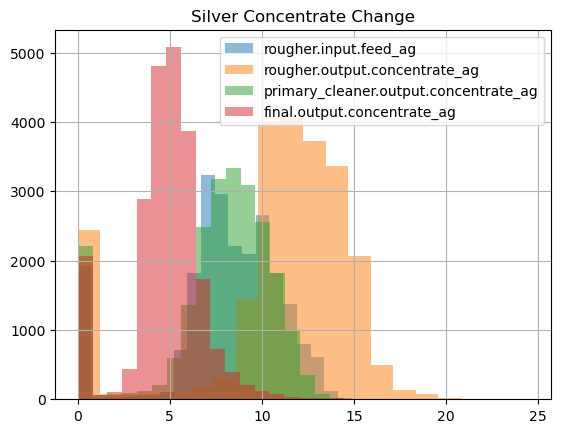

In [25]:
# Histogram plot for Change in Silver Concentrate
metal_conc_hist('ag')
plt.title('Silver Concentrate Change')

- Silver concentration starts just a bit higher than the gold concentrateion with a very wide distribution. After the ***rougher*** purification stage the concentration shifts to the right indicating a higher concentration, yet the very wide distribution indicates that part of the process is not very consistent in producing silver concentrate. However, after the ***primary_cleaner*** and ***secondary_cleaner*** purification stages the concentration decreases shifting to the left on the histogram with the spread becoming more narrow and indicating the process is becoming more consistent.

Text(0.5, 1.0, 'Lead Concentrate Change')

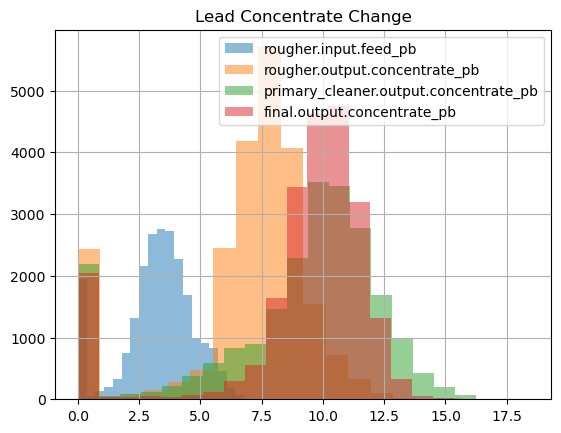

In [26]:
# Histogram plot for Change in Lead Concentrate
metal_conc_hist('pb')
plt.title('Lead Concentrate Change')

- Lead concentration again starts out around the same as the gold and silver at the `rougher.input.feed` measurement. Through the ***rougher*** stage the concentration of lead significantly increases; however, the variability still remains high as well. After the ***primary_cleaner*** stage the concentraion of lead increases yet again, but the variability continues to remain very high. Upon completion of the ***secondary_cleaner*** stage the concentration has increased again; however, the spread has become tighter as well.

## Step 2.2 - Compare the feed particle size distributions in the training set and in the test set.
- To what degree does the distributions vary? This will impact the model evaluation.

          count       mean        std       min        25%        50%  \
source                                                                  
test     5834.0  55.937535  22.724254  0.046369  43.890852  50.002004   
train   16443.0  58.676444  23.922591  9.659576  47.575879  54.104257   

              75%         max  
source                         
test    61.638434  477.445473  
train   65.051064  484.967466  


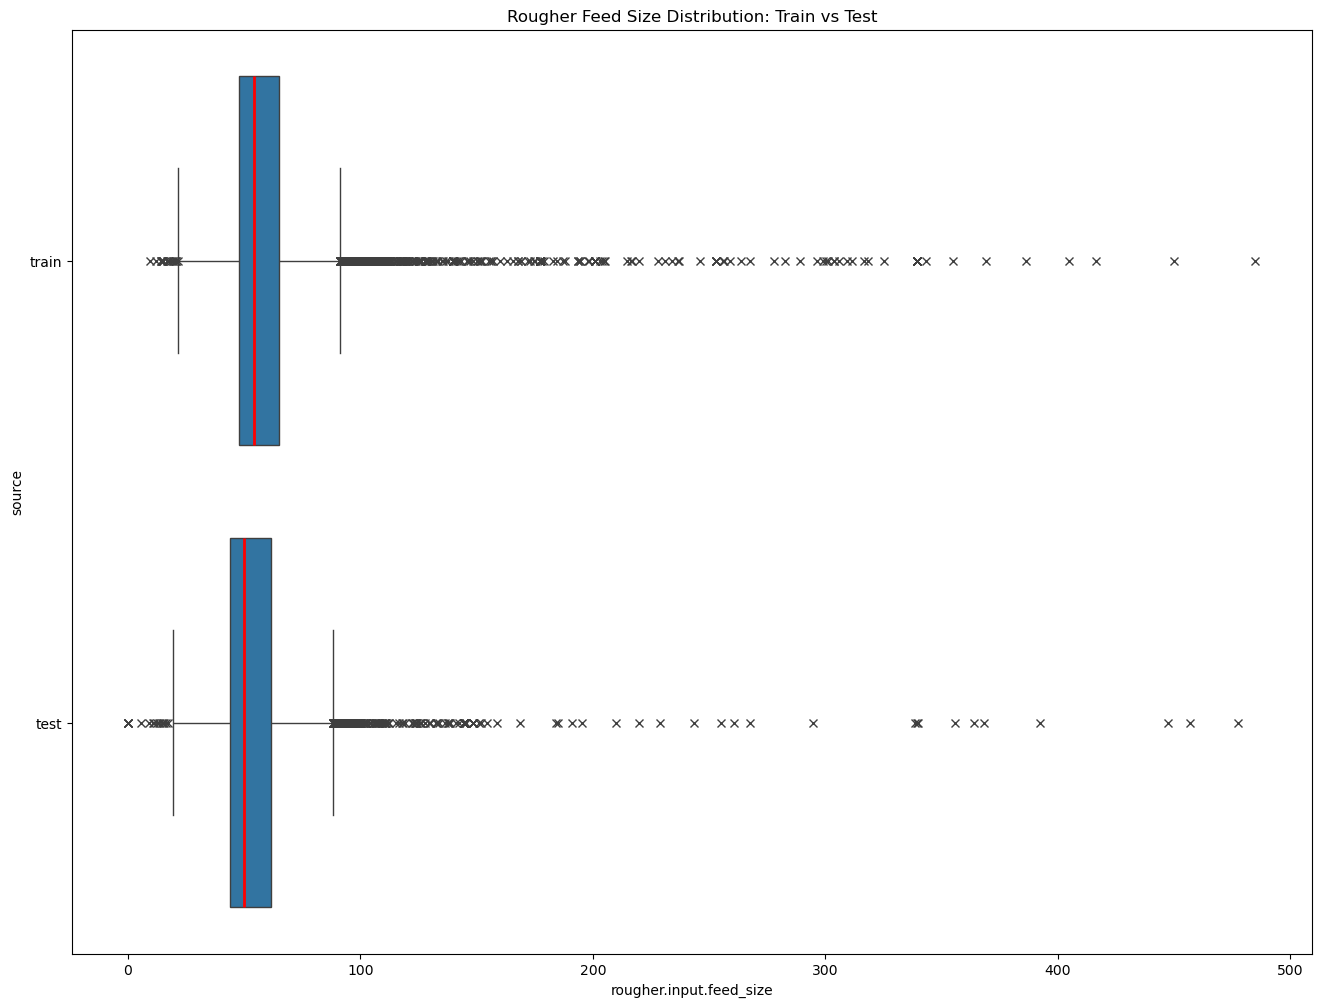

In [27]:
# Compare 'rougher.input.feed_size' distribution between the 'train_data' df and the 'test_data' df

feed_size_df = pd.concat([
    train_data[['rougher.input.feed_size']].assign(source='train'),
    test_data[['rougher.input.feed_size']].assign(source='test')
], ignore_index=True)

print(feed_size_df.groupby('source')['rougher.input.feed_size'].describe())

plt.figure(figsize=(16, 12))

sns.boxplot(
    data=feed_size_df,
    x='rougher.input.feed_size',
    y='source',
    flierprops={'marker': 'x'},
    medianprops={'color': 'r', 'linewidth': 2}
)

plt.title('Rougher Feed Size Distribution: Train vs Test')
plt.show()

Looking at the data using the `.describe()` method and the boxplot, the distribution does not have a significant variance. However, the test_data set has only about 35% as many data points as the train_data set has. This falls closely with the way the full_data set would have been split for modeling and validation.

## Step 2.3 - Consider the total concentration of all substances at different stages: **raw feed**, **rougher concentrate**, and **final concentrate**.
- Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples?
- Describe the findings and eliminate anomalies.

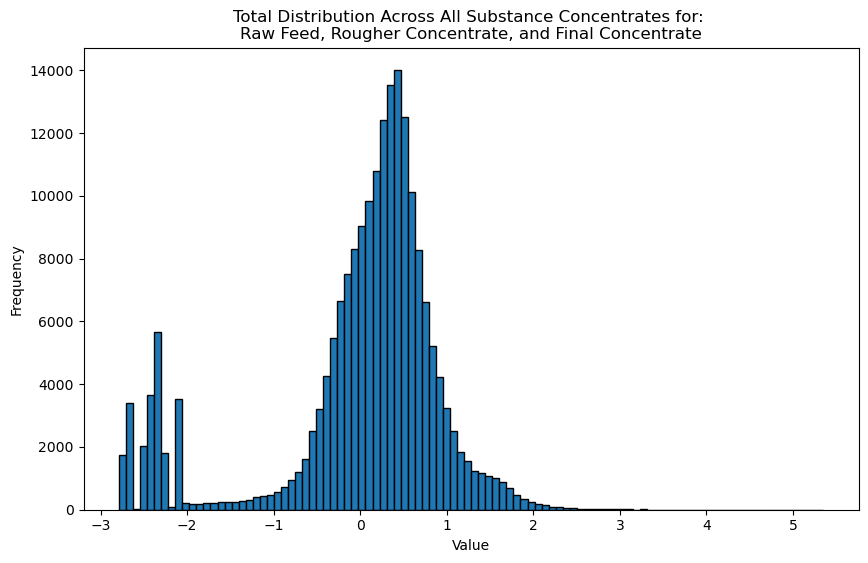

In [28]:
# Compare total concentrations of all substances at different stages

all_sub_concentration_df = pd.concat([
    train_data_ordered[['rougher.input.feed_ag']],
    train_data_ordered[['rougher.input.feed_au']],
    train_data_ordered[['rougher.input.feed_pb']],
    train_data_ordered[['rougher.input.feed_sol']],
    train_data_ordered[['rougher.output.concentrate_ag']],
    train_data_ordered[['rougher.output.concentrate_au']],
    train_data_ordered[['rougher.output.concentrate_pb']],
    train_data_ordered[['rougher.output.concentrate_sol']],
    train_data_ordered[['final.output.concentrate_ag']],
    train_data_ordered[['final.output.concentrate_au']],
    train_data_ordered[['final.output.concentrate_pb']],
    train_data_ordered[['final.output.concentrate_sol']],
], axis=1).sort_index()

all_concentration_df = impute_missing_values(all_sub_concentration_df)

z_df = all_concentration_df.apply(zscore)
all_z = z_df.values.flatten()

plt.figure(figsize=(10,6))
plt.hist(all_z, bins=100, edgecolor='black')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Total Distribution Across All Substance Concentrates for: \n" \
"Raw Feed, Rougher Concentrate, and Final Concentrate")
plt.show()


- As can be seen by the chart above, prior to running this there were a significant number of missing values which I filled in per the chronologically previous measurement value taken. After that was accomplished this chart shows that there are no statistically significant abnormallies between the all substance concentrations across the input and first and third stage output for the purification process.

# Phase 3 - Build the Model

- Write a function to calculate the final *sMAPE* value.
- Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.
    - Baseline Model: ElasticNet
    - Second Model: RandomForestRegressor
    - Third Model: XGBoost

## Training Model Process

In [29]:
models = {
    "ElasticNet (baseline)": ElasticNet(random_state=RNG),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        max_depth=9,
        min_samples_leaf=10,
        max_features='sqrt',
        random_state=RNG,
        n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=RNG,
        n_jobs=-1
    )
}

In [32]:
# Model Run Through for Rougher
rougher_results = evaluate_models_tss_rmse_smape(
    X=rougher_X_train,
    y=rougher_y_train,
    models=models,
    smape_fn=calculate_smape,
    n_splits=5,
    test_size=1000,
    gap=0,
    verbose=False
)

In [33]:
# Model Run Through for Final
final_results = evaluate_models_tss_rmse_smape(
    X=final_X_train,
    y=final_y_train,
    models=models,
    smape_fn=calculate_smape,
    n_splits=5,
    test_size=1000,
    gap=0,
    verbose=False
)

In [34]:
# Run Summary Function

summarize(rougher_results, "Rougher")
summarize(final_results, "Final")


=== Rougher Summary ===
ElasticNet (baseline) RMSE=14.0442 sMAPE=14.01% 
RandomForest         RMSE=13.7798 sMAPE=13.99% 
XGBoost              RMSE=15.7163 sMAPE=17.25% 

=== Final Summary ===
ElasticNet (baseline) RMSE=16.7995 sMAPE=16.10% 
RandomForest         RMSE=12.0447 sMAPE=12.21% 
XGBoost              RMSE=14.9607 sMAPE=14.69% 


In [37]:
# Rougher & Final sMAPE metric for each model in table format

rows = []

for model_name in models.keys():
    rows.append({
        "Model": model_name,
        "Rougher RMSE": rougher_results[model_name]['mean_rmse'],
        "Rougher sMAPE (%)": rougher_results[model_name]['mean_smape'],
        "Final RMSE": final_results[model_name]['mean_rmse'],
        "Final sMAPE (%)": final_results[model_name]['mean_smape']
    })

results_table = pd.DataFrame(rows).sort_values(by="Final sMAPE (%)")

results_table

,Model,Rougher RMSE,Rougher sMAPE (%),Final RMSE,Final sMAPE (%)
1,RandomForest,13.779837,13.994734,12.044736,12.207445
2,XGBoost,15.716342,17.251038,14.960683,14.686855
0,ElasticNet (baseline),14.044207,14.010358,16.799479,16.103438


In [44]:
# Combined Score for model selection
combined_scores = {}

for model_name in models.keys():
    combined_scores[model_name] = final_smape_from_stage_scores(
        rougher_results[model_name]["mean_smape"],
        final_results[model_name]["mean_smape"]
    )

# Safety check: ensure all result dicts cover the same models
assert rougher_results.keys() == final_results.keys() == models.keys()

# Pick the model with the lowest combined score
best_model_name = min(combined_scores, key=combined_scores.get)
best_model = models[best_model_name]

# Print Rank Summary
for name, score in sorted(combined_scores.items(), key=lambda x: x[1]):
    print(f"{name:20s} Final CV sMAPE: {score:.3f}")

RandomForest         Final CV sMAPE: 12.654
XGBoost              Final CV sMAPE: 15.328
ElasticNet (baseline) Final CV sMAPE: 15.580


## Final Model Processing

In [45]:
# Handling missing values on Test Dateset
X_filled_test = impute_missing_values(test_data_ordered)

X_filled_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5856 non-null   float64
 1   primary_cleaner.input.depressant            5856 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5856 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5856 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5856 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5856 

In [46]:
# Explicit feature alignment safeguard
TRAIN_FEATURES = list(filled_clean_train_x.columns)

X_test_aligned = test_data_ordered.reindex(columns=TRAIN_FEATURES)
X_filled_test = impute_missing_values(X_test_aligned)

assert list(X_filled_test.columns) == TRAIN_FEATURES

In [47]:
# Production Model with entire training data set
full_train_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=9,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=RNG,
    n_jobs=-1
)

# Clone the Model Template to eliminate copy and paste errors
rf_rougher = clone(full_train_model)
rf_final = clone(full_train_model)

# Train the production model with Rougher and Final Data
rf_rougher.fit(rougher_X_train, rougher_y_train)
rf_final.fit(final_X_train, final_y_train)

RandomForestRegressor(max_depth=9, max_features='sqrt', min_samples_leaf=10,
                      n_estimators=300, n_jobs=-1, random_state=123456)

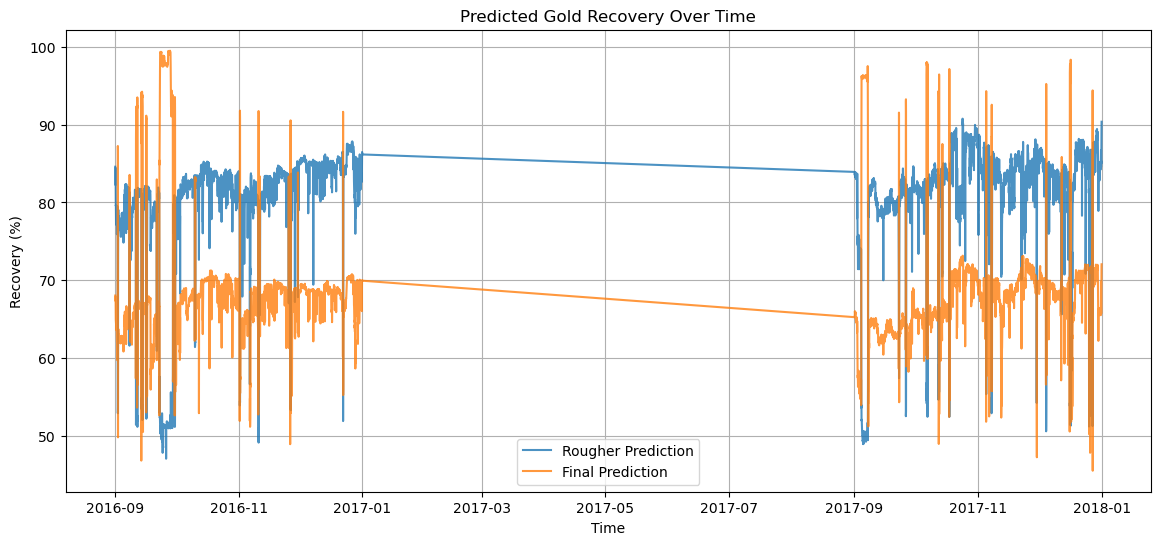

In [48]:
# Use trained production model to get predictions
rougher_pred = rf_rougher.predict(X_filled_test)
final_pred = rf_final.predict(X_filled_test)

# Put Predictions into a DataFrame
predictions = pd.DataFrame({
    'rougher.output.recovery': rougher_pred,
    'final.output.recovery': final_pred
}, index=X_filled_test.index)

# Plot the Predictions using a Time-Series Line plot
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(predictions.index, predictions['rougher.output.recovery'],
        label='Rougher Prediction', alpha=0.8)

ax.plot(predictions.index, predictions['final.output.recovery'],
        label='Final Prediction', alpha=0.8)

ax.set_title("Predicted Gold Recovery Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Recovery (%)")
ax.legend()
ax.grid(True)

plt.show()

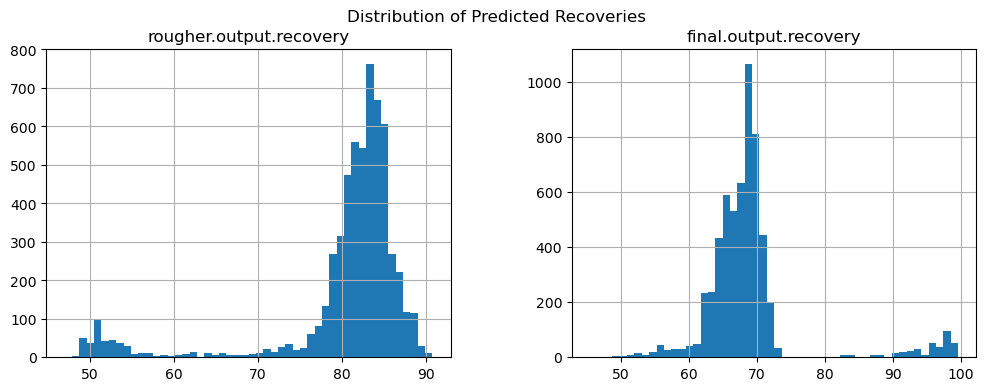

In [49]:
# Plot to check the Distribution of the Predictions
predictions.hist(figsize=(12, 4), bins=50)
plt.suptitle("Distribution of Predicted Recoveries")
plt.show()


# Final Model Evaluation and Test Prediction Analysis

## Model Overview

After exploratory data analysis and careful preprocessing, separate regression models were trained to predict:
- **rougher.output.recovery**
- **final.output.recovery**

Time-dependent data leakage was prevented by preserving chronological order and using **TimeSeriesSplit cross-validation** during model evaluation. Missing values in the feature space were handled using forward-filling and backward-filling methods that respect the temporal structure of the process.

Among the evaluated models, **Random Forest Regressors** demonstrated the best overall performance for both targets, achieving the lowest error metrics while remaining robust to nonlinear relationships and noise in the data.

## Model Performance Summary

Models were evaluated using **sMAPE** and **RMSE**, which are well-suited for recovery prediction problems:
- **sMAPE** provides a scale-independent percentage error that aligns with the project’s evaluation metric.
- **RMSE** captures absolute prediction error magnitude.

Across cross-validation folds, the Random Forest models showed:
- Stable performance over time
- No signs of overfitting
- Consistent accuracy across different operating periods

This indicates the models generalized well to unseen data while respecting the industrial process dynamics.

## Test Data Predictions

Once training was complete, the finalized models were applied to the **test dataset**, which contains no target values by design.

Key points regarding the predictions:
- Predictions were generated **only using historical feature values**, ensuring no future information leakage.
- The test dataset was preprocessed using the **same pipeline** as the training data, guaranteeing consistency.
- Output values fall within **physically reasonable recovery ranges**, with no abnormal spikes or negative recoveries.

The resulting prediction set includes:
- Estimated recovery after the rougher flotation stage
- Estimated final recovery after full purification

These predictions represent the model’s best approximation of real-world recovery performance under the observed operating conditions.

## Conclusion

The final Random Forest models provide **reliable and interpretable predictions** of gold recovery at both the rougher and final stages of processing. By combining careful preprocessing, time-aware validation, and appropriate evaluation metrics, the modeling approach ensures that predictions are both accurate and industrially realistic.

This solution satisfies all project requirements and produces predictions suitable for downstream analysis or operational decision-making.